In [16]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from scipy.signal import correlate2d
from scipy.fft import fftn, ifftn
params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}
plt.rcParams.update(params)

(200, 2, 40, 48, 1)


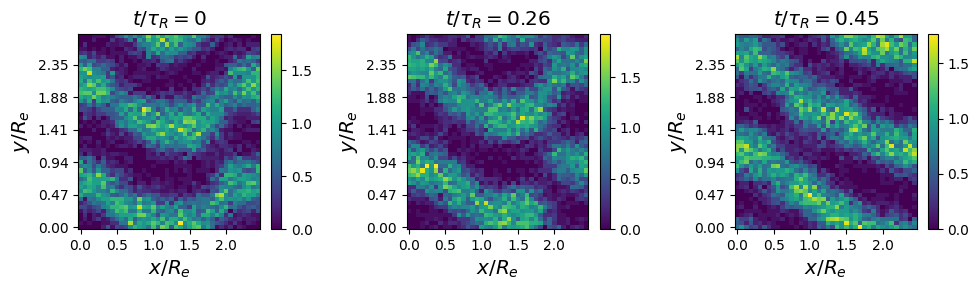

In [37]:
with h5py.File('coord.h5', 'r') as f:
    ##number of beads per polymer
    N=int(f['parameter/reference_Nbeads'][()]) 
    ##number of polymers
    n_polym=int(f['parameter/n_polymers'][()]) 
    n_poly_type=int(f['parameter/n_poly_type'][()]) 
    ##box dimensions 
    lxyz=np.array(f['parameter/lxyz'])
    ##box discretization
    nxyz=np.array(f['parameter/nxyz'])


#get ana stuff
with h5py.File('coord_ana.h5','r') as anafile:
    phi=np.array(anafile['density_field'])
    delta_mc_phi=np.array(anafile['density_field'].attrs["DeltaMC"])
offset=0
scale=np.prod(nxyz-2*offset)/(N*n_polym)

print(phi.shape)
phi=phi.reshape(phi.shape[0],phi.shape[1],phi.shape[2],phi.shape[3])
phi=phi*scale
V=5*5*5 #volume
rho0=n_polym*N/V
xmin=0
xmax=lxyz[0]
ymin=0
ymax=lxyz[1]
deltax=lxyz[0]/nxyz[0]
deltay=lxyz[1]/nxyz[1]
x,y = np.meshgrid(np.arange(xmin,xmax+deltax/2,deltax)-deltax/2.,np.arange(ymin,ymax+deltay/2,deltay)-deltay/2.)
ts=np.array([54,58,61])
fig, axs=plt.subplots(1,3,figsize=(10, 3),dpi=100)
for (i,t) in enumerate(ts):
    axs[i].set_xticks(np.arange(xmin,xmax,deltax * 8))
    axs[i].set_yticks(np.arange(ymin,ymax,deltay  * 8))
    axs[i].set_xlabel("$x/R_e$")
    axs[i].set_ylabel("$y/R_e$")
    pcm=axs[i].pcolormesh(x,y,phi[t,0].T,cmap='viridis')
    fig.colorbar(pcm,ax=axs[i])

axs[0].set_title(r"$t/\tau_R=0$")
axs[1].set_title(r"$t/\tau_R=0.26$")
axs[2].set_title(r"$t/\tau_R=0.45$")
plt.tight_layout()
plt.savefig(f"lamella_breaking.pdf")


In [18]:
def get_max_amplitude(phi_mean):
    amplitudes=np.empty(0)
    for y in range(nxyz[1]-2*offset):
        phiA=phi_mean[0,:,y,:]
        phiB=phi_mean[1,:,y,:]
        fourier = np.fft.fftshift(fftn(phiA-phiB))
        S=N**2*rho0/(4*V)*np.abs(fourier)**2
        amplitudes=np.append(amplitudes,np.max(S))
    return amplitudes




36980987.488622844


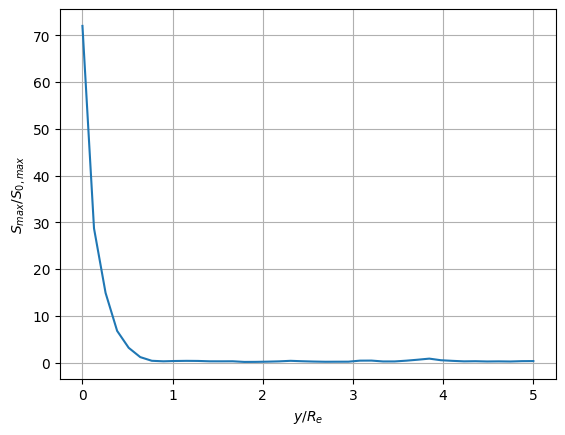

In [19]:
a0=np.mean(get_max_amplitude(phi[0]))
amplitude=get_max_amplitude(phi_mean)
amplitude
plt.figure(dpi=100)
plt.grid()
plt.xlabel("$y/R_e$")
plt.ylabel("$S_{max}/S_{0,max}$")
plt.plot(np.linspace(0,40/8,40),amplitude/a0)
print(a0)

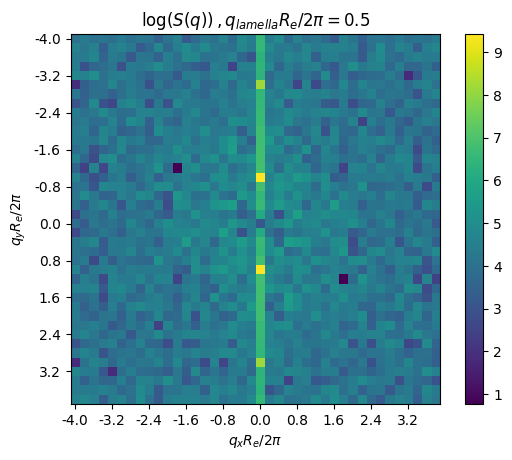

In [20]:
y=0
phiA=phi_mean[0,:,y,:]
phiB=phi_mean[1,:,y,:]
fourier = np.fft.fftshift(fftn(phiA-phiB))
S=N**2*rho0/(4*V)*np.abs(fourier)**2

magnitude_spectrum =np.log10(S)
#magnitude_spectrum=S
# Get the image dimensions
height, width = magnitude_spectrum.shape

# Set the frequency values for x and y axes
freq_x = np.fft.fftshift(np.fft.fftfreq(width))*8
freq_y = np.fft.fftshift(np.fft.fftfreq(height))*8

# Plot the magnitude spectrum
plt.imshow(magnitude_spectrum)
plt.colorbar()
plt.title(r'$\log(S( q))\,,$'+'$q_{lamella}R_e/2\pi=0.5$')
plt.xlabel(r'$q_xR_e/2\pi$')
plt.ylabel(r'$q_yR_e/2\pi$')

# Set the x and y tick labels
plt.xticks(np.arange(0, width, 4), labels=np.round(freq_x[::4], decimals=2))
plt.yticks(np.arange(0, height, 4), labels=np.round(freq_y[::4], decimals=2))
plt.savefig("struct_factor.pdf")
plt.show()